# Visual Information Analysis - Session 2: Image Filtering Tutorial

This notebook covers:
1. Spatial Domain Filter
2. Ideal Low-Pass Filter (Frequency Domain)
3. Butterworth Low-Pass Filter (Frequency Domain)
4. Gaussian Low-Pass Filter (Frequency Domain)
5. Ideal High-Pass Filter (Frequency Domain)
6. Butterworth High-Pass Filter (Frequency Domain)
7. Gaussian High-Pass Filter (Frequency Domain)
8. Laplacian Filter (Frequency Domain)

---

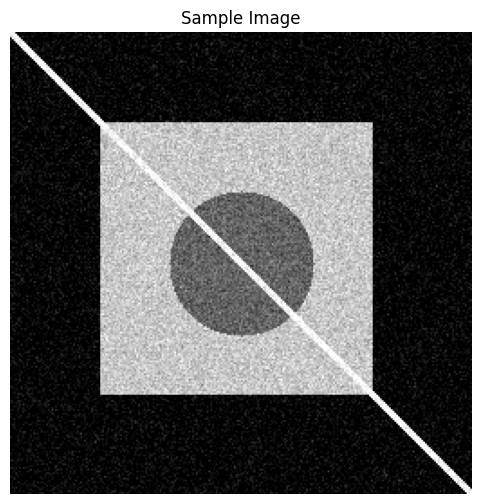

Image shape: (256, 256)
Setup complete!


In [39]:

import cv2
import numpy as np
import matplotlib.pyplot as plt

# Create a sample image
def create_sample_image():
    img = np.zeros((256, 256), dtype=np.uint8)
    cv2.rectangle(img, (50, 50), (200, 200), 200, -1)
    cv2.circle(img, (128, 128), 40, 100, -1)
    cv2.line(img, (0, 0), (255, 255), 255, 2)
    noise = np.random.normal(0, 20, img.shape)
    img = np.clip(img + noise, 0, 255).astype(np.uint8)
    return img

# Load image
image = create_sample_image()

# Or upload your own image:
# from google.colab import files
# uploaded = files.upload()
# image = cv2.imread(list(uploaded.keys())[0], cv2.IMREAD_GRAYSCALE)

plt.figure(figsize=(6, 6))
plt.imshow(image, cmap='gray')
plt.title('Sample Image')
plt.axis('off')
plt.show()

print(f"Image shape: {image.shape}")
print("Setup complete!")

---
## **1. Spatial Domain Filters**

**Built-in OpenCV Functions:**
- `cv2.blur()` - Mean filter
- `cv2.GaussianBlur()` - Gaussian filter
- `cv2.medianBlur()` - Median filter


These filters work directly on pixel values by sliding a small window (kernel) across the image and replacing each pixel with a weighted average of its neighbors. Mean filter takes a simple average (blurs uniformly), Gaussian filter gives more weight to center pixels (natural blur), and Median filter picks the middle value (great for removing salt-and-pepper noise while preserving edges).

In [40]:
#image = r"/content/drive/MyDrive/workshop 2 /Images/Building3.jpg"

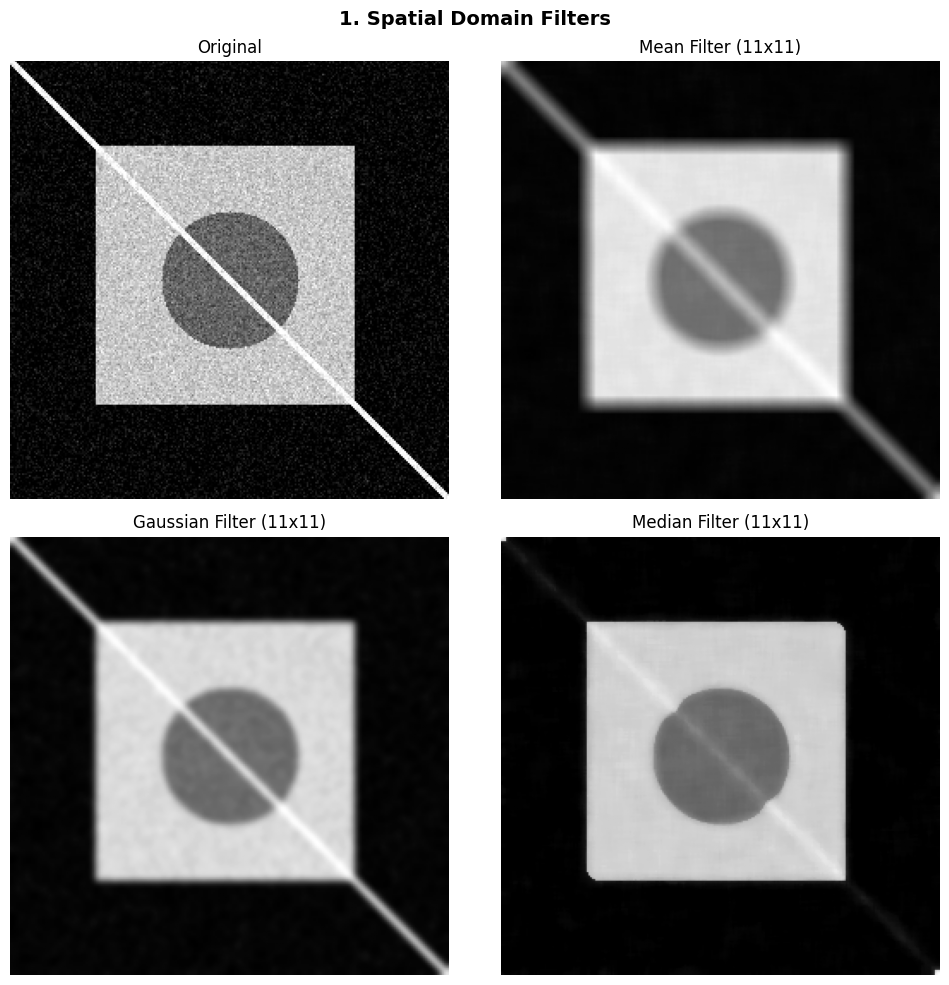

In [41]:
# 1. SPATIAL DOMAIN FILTERS

# Load the image from the path if it's a string
if isinstance(image, str):
    image = cv2.imread(image, cv2.IMREAD_GRAYSCALE)
    if image is None:
        raise ValueError("Image not loaded. Check the path or file existence.")

kernel_size = 11

# Mean Filter (Box Filter)
mean_filtered = cv2.blur(image, (kernel_size, kernel_size))

# Gaussian Filter
gaussian_filtered = cv2.GaussianBlur(image, (kernel_size, kernel_size), 0)

# Median Filter
median_filtered = cv2.medianBlur(image, kernel_size)

# Display
fig, ax = plt.subplots(2, 2, figsize=(10, 10))

ax[0, 0].imshow(image, cmap='gray')
ax[0, 0].set_title('Original')
ax[0, 0].axis('off')

ax[0, 1].imshow(mean_filtered, cmap='gray')
ax[0, 1].set_title(f'Mean Filter ({kernel_size}x{kernel_size})')
ax[0, 1].axis('off')

ax[1, 0].imshow(gaussian_filtered, cmap='gray')
ax[1, 0].set_title(f'Gaussian Filter ({kernel_size}x{kernel_size})')
ax[1, 0].axis('off')

ax[1, 1].imshow(median_filtered, cmap='gray')
ax[1, 1].set_title(f'Median Filter ({kernel_size}x{kernel_size})')
ax[1, 1].axis('off')

plt.suptitle('1. Spatial Domain Filters', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

---
## Frequency Domain Setup

Before applying frequency domain filters, we need to:
1. Compute the DFT (Discrete Fourier Transform)
2. Shift zero frequency to center
3. Create a distance matrix from center

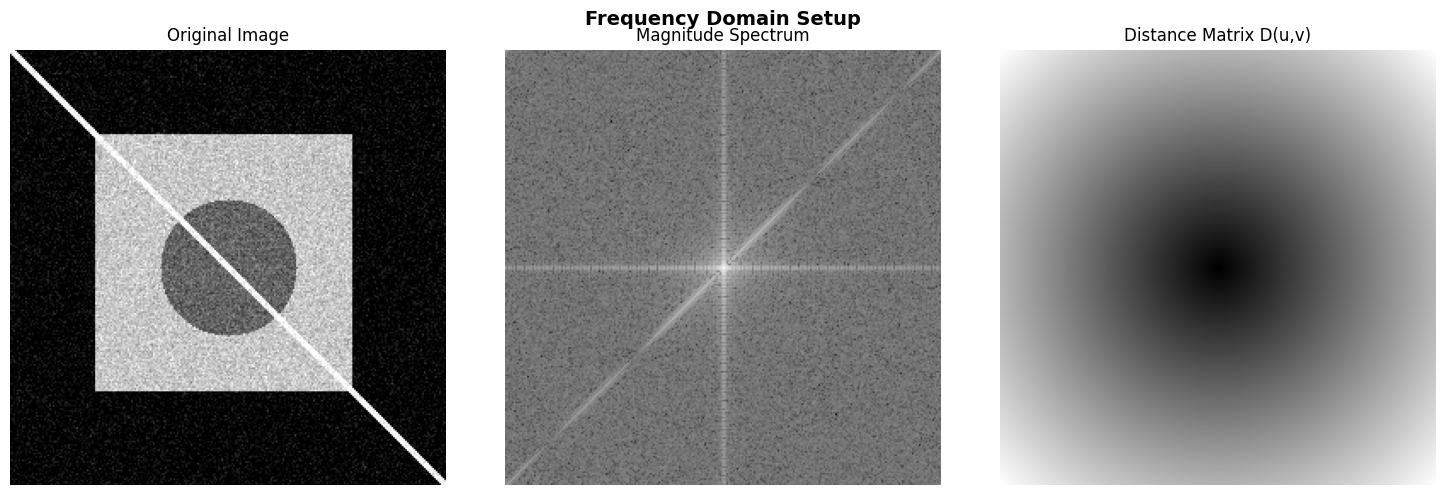

Image size: 256 x 256
Center: (128, 128)
Max distance: 181.02


In [42]:
# FREQUENCY DOMAIN SETUP

# Step 1: Compute DFT
dft = np.fft.fft2(image)

# Step 2: Shift zero frequency to center
dft_shift = np.fft.fftshift(dft)

# Step 3: Calculate magnitude spectrum for visualization
magnitude_spectrum = 20 * np.log(np.abs(dft_shift) + 1)

# Step 4: Create distance matrix (D)
rows, cols = image.shape
crow, ccol = rows // 2, cols // 2  # Center

u = np.arange(rows) - crow
v = np.arange(cols) - ccol
V, U = np.meshgrid(v, u)
D = np.sqrt(U**2 + V**2)  # Distance from center

# Display
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

ax[0].imshow(image, cmap='gray')
ax[0].set_title('Original Image')
ax[0].axis('off')

ax[1].imshow(magnitude_spectrum, cmap='gray')
ax[1].set_title('Magnitude Spectrum')
ax[1].axis('off')

ax[2].imshow(D, cmap='gray')
ax[2].set_title('Distance Matrix D(u,v)')
ax[2].axis('off')

plt.suptitle('Frequency Domain Setup', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print(f"Image size: {rows} x {cols}")
print(f"Center: ({crow}, {ccol})")
print(f"Max distance: {D.max():.2f}")

# Frequency Domain Setup - Explanation

This image shows the **foundation for all frequency domain filters**.

---

## The Three Images

### 1. Original Image (Left)

A synthetic test image containing:

- A **white rectangle** (sharp edges)
- A **gray circle** inside
- A **diagonal line**
- **Gaussian noise** added throughout

This gives us various features to filter: edges, shapes, and noise.

---

### 2. Magnitude Spectrum (Center)

The **Fourier Transform** of the image visualized.

| Location | Meaning |
|----------|---------|
| **Center** | Low frequencies (slow changes, smooth areas) |
| **Edges** | High frequencies (fast changes, details, edges) |

The bright lines correspond to edges in the original:

- **Horizontal/Vertical lines** → from the rectangle edges
- **Diagonal line** → from the diagonal line in the image

---

### 3. Distance Matrix D(u,v) (Right)

Shows the **distance from center** for each point.

| Color | Distance | Frequency |
|-------|----------|-----------|
| **Black (center)** | D = 0 | Zero frequency |
| **White (edges)** | D = max | Highest frequencies |

This matrix is used in **all filter formulas**.

---

## Key Values

| Parameter | Value |
|-----------|-------|
| Image size | 256 × 256 pixels |
| Center | (128, 128) |
| Max distance | 181.02 pixels |

> **Note:** Max distance = √(128² + 128²) ≈ 181.02

---

## Why This Matters

All frequency domain filters use the distance **D** to decide what to keep or remove:

| Filter Type | Rule |
|-------------|------|
| **Low-pass** | Keep where D is **small** (near center) → Blurring |
| **High-pass** | Keep where D is **large** (near edges) → Edge detection |

---

## The Distance Formula

$$D(u,v) = \sqrt{(u - M/2)^2 + (v - N/2)^2}$$

Where:
- `M × N` = image dimensions
- `(M/2, N/2)` = center coordinates
- `D(u,v)` = distance from center at point (u,v)

---

## Python Code

```python
# Create distance matrix
rows, cols = image.shape
crow, ccol = rows // 2, cols // 2  # Center

u = np.arange(rows) - crow
v = np.arange(cols) - ccol
V, U = np.meshgrid(v, u)
D = np.sqrt(U**2 + V**2)  # Distance from center
```

---
## **2. Ideal Low-Pass Filter**

**Formula:**
$$H(u,v) = \begin{cases} 1 & \text{if } D(u,v) \leq D_0 \\ 0 & \text{if } D(u,v) > D_0 \end{cases}$$

**Effect:** Sharp cutoff, may cause ringing artifacts

This filter acts like a perfect wall in the frequency domain - it completely passes all frequencies inside a circle (radius D₀) and completely blocks everything outside. The result is a blurred image because high frequencies (edges, details, noise) are removed. However, the sharp cutoff creates unwanted "ringing" artifacts around edges.

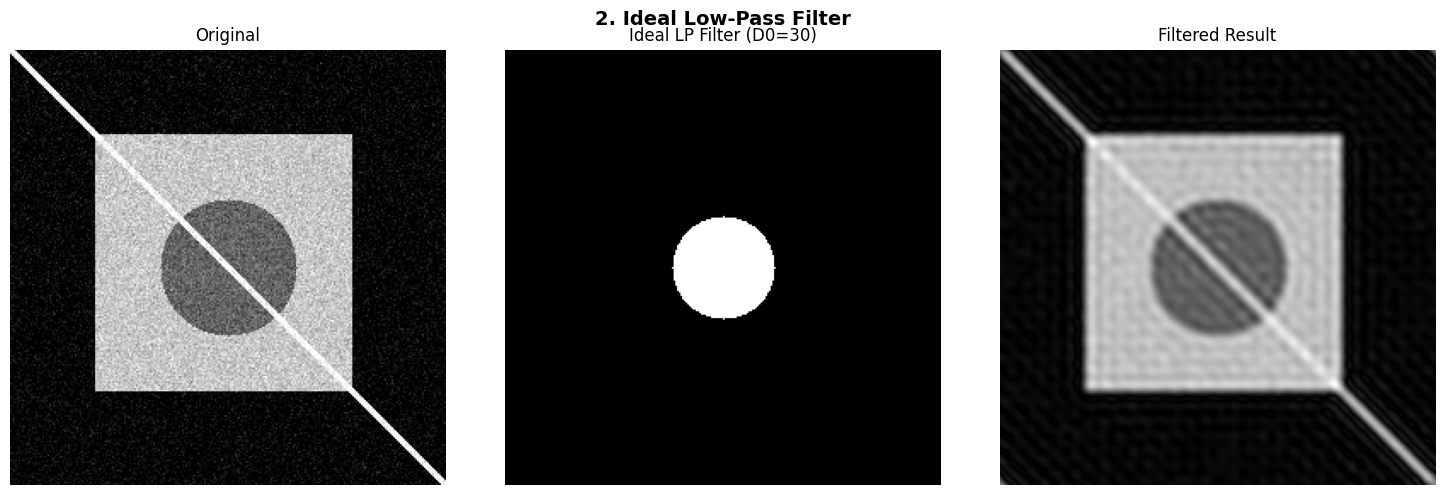

Formula: H(u,v) = 1 if D(u,v) <= 30, else 0


In [43]:
# 2. IDEAL LOW-PASS FILTER

D0 = 30  # Cutoff frequency (try different values: 10, 30, 50, 80)

# Create filter mask
H_ideal_lp = np.zeros((rows, cols), dtype=np.float32)
H_ideal_lp[D <= D0] = 1

# Apply filter in frequency domain
filtered_dft = dft_shift * H_ideal_lp

# Inverse DFT
f_ishift = np.fft.ifftshift(filtered_dft)
result = np.abs(np.fft.ifft2(f_ishift))

# Display
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

ax[0].imshow(image, cmap='gray')
ax[0].set_title('Original')
ax[0].axis('off')

ax[1].imshow(H_ideal_lp, cmap='gray')
ax[1].set_title(f'Ideal LP Filter (D0={D0})')
ax[1].axis('off')

ax[2].imshow(result, cmap='gray')
ax[2].set_title('Filtered Result')
ax[2].axis('off')

plt.suptitle('2. Ideal Low-Pass Filter', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print(f"Formula: H(u,v) = 1 if D(u,v) <= {D0}, else 0")

## Formula

$$H(u,v) = \begin{cases} 1 & \text{if } D(u,v) \leq D_0 \\ 0 & \text{if } D(u,v) > D_0 \end{cases}$$

---

## The Three Images

| Image | Description |
|-------|-------------|
| **Original** | Input image with noise and edges |
| **Filter Mask** | White circle (D₀=30) = pass, Black = block |
| **Result** | Blurred image (high frequencies removed) |

---

## Key Points

- **Low frequencies** (center) → **Kept** → smooth areas
- **High frequencies** (outside circle) → **Blocked** → edges, noise removed
- **Ringing artifacts** visible due to sharp cutoff

---

## Parameter

| D₀ | Effect |
|----|--------|
| Small (10) | More blur |
| Large (80) | Less blur |

> **Note:** Sharp cutoff causes ringing. Use Butterworth/Gaussian for smoother results.

---
## **3. Butterworth Low-Pass Filter**

**Formula:**
$$H(u,v) = \frac{1}{1 + \left(\frac{D(u,v)}{D_0}\right)^{2n}}$$

**Effect:** Smooth transition, minimal ringing


This filter does the same job as the Ideal LP (blurring) but with a gradual transition instead of a sharp cutoff. Frequencies smoothly fade from "pass" to "block" based on the order parameter (n). This eliminates the ringing artifacts while still achieving effective blurring - making it more practical for real applications.

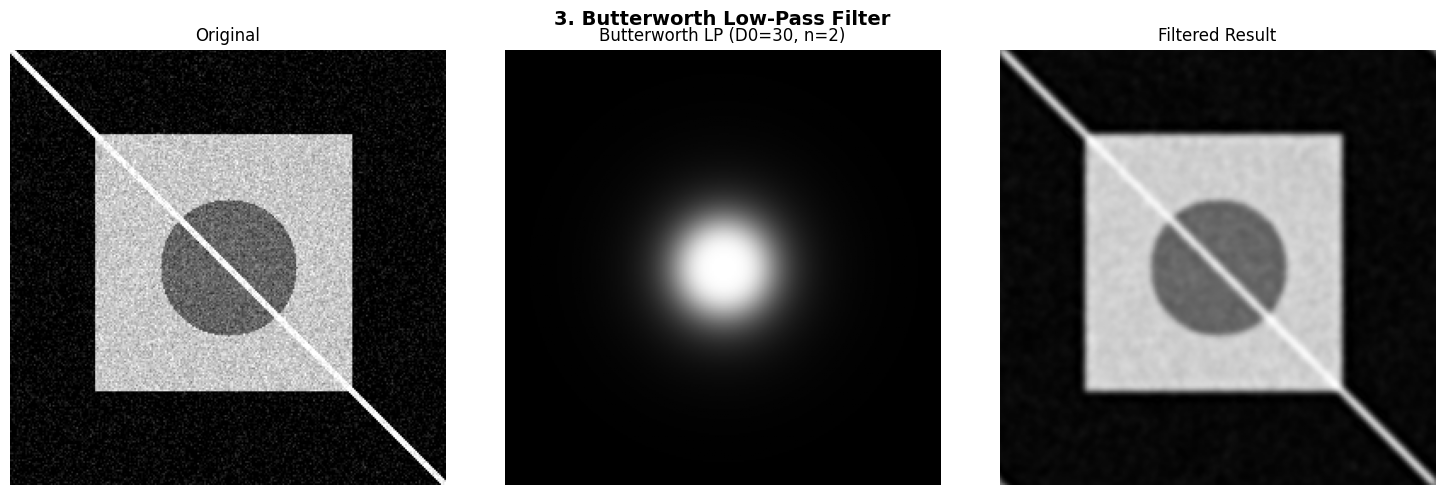

Formula: H(u,v) = 1 / (1 + (D/30)^4)


In [44]:
# 3. BUTTERWORTH LOW-PASS FILTER

D0 = 30  # Cutoff frequency
n = 2    # Filter order (try: 1, 2, 3, 4)

# Create filter mask
H_butter_lp = 1 / (1 + (D / D0) ** (2 * n))

# Apply filter
filtered_dft = dft_shift * H_butter_lp

# Inverse DFT
f_ishift = np.fft.ifftshift(filtered_dft)
result = np.abs(np.fft.ifft2(f_ishift))

# Display
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

ax[0].imshow(image, cmap='gray')
ax[0].set_title('Original')
ax[0].axis('off')

ax[1].imshow(H_butter_lp, cmap='gray')
ax[1].set_title(f'Butterworth LP (D0={D0}, n={n})')
ax[1].axis('off')

ax[2].imshow(result, cmap='gray')
ax[2].set_title('Filtered Result')
ax[2].axis('off')

plt.suptitle('3. Butterworth Low-Pass Filter', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print(f"Formula: H(u,v) = 1 / (1 + (D/{D0})^{2*n})")

## Formula

$$H(u,v) = \frac{1}{1 + \left(\frac{D(u,v)}{D_0}\right)^{2n}}$$

---

## The Three Images

| Image | Description |
|-------|-------------|
| **Original** | Input image with noise and edges |
| **Filter Mask** | Gradual transition (white→gray→black) |
| **Result** | Smooth blur, **no ringing** |

---

## Key Points

- **Smooth transition** from pass to block (unlike Ideal's sharp cutoff)
- **No ringing artifacts** - edges are clean
- At D = D₀: H = 0.5 (half-power point)

---

## Parameters

| Parameter | Value | Effect |
|-----------|-------|--------|
| **D₀** | 30 | Cutoff frequency (same as Ideal) |
| **n** | 2 | Order - higher = sharper transition |

| Order (n) | Behavior |
|-----------|----------|
| n = 1 | Very smooth |
| n = 2 | Moderate (common) |
| n → ∞ | Approaches Ideal filter |

> **Advantage over Ideal:** Smooth transition eliminates ringing artifacts.

---
## **4. Gaussian Low-Pass Filter**

**Formula:**
$$H(u,v) = e^{-\frac{D(u,v)^2}{2D_0^2}}$$

**Effect:** Smoothest transition, no ringing artifacts

This is the smoothest low-pass filter, using a Gaussian (bell curve) shape for the transition. It provides the cleanest blur with absolutely no ringing artifacts. It's the simplest to use (no order parameter) and produces the most natural-looking results, making it the preferred choice when you want smooth blurring.

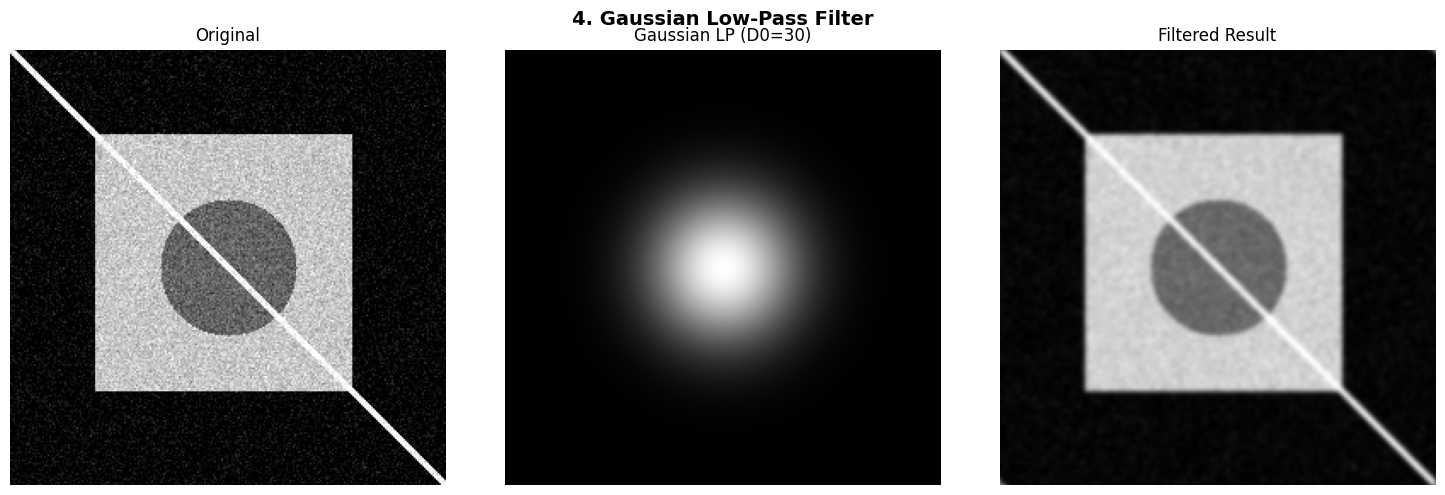

Formula: H(u,v) = exp(-D² / (2 * 30²))


In [45]:
# 4. GAUSSIAN LOW-PASS FILTER

D0 = 30  # Cutoff frequency

# Create filter mask
H_gauss_lp = np.exp(-(D ** 2) / (2 * (D0 ** 2)))

# Apply filter
filtered_dft = dft_shift * H_gauss_lp

# Inverse DFT
f_ishift = np.fft.ifftshift(filtered_dft)
result = np.abs(np.fft.ifft2(f_ishift))

# Display
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

ax[0].imshow(image, cmap='gray')
ax[0].set_title('Original')
ax[0].axis('off')

ax[1].imshow(H_gauss_lp, cmap='gray')
ax[1].set_title(f'Gaussian LP (D0={D0})')
ax[1].axis('off')

ax[2].imshow(result, cmap='gray')
ax[2].set_title('Filtered Result')
ax[2].axis('off')

plt.suptitle('4. Gaussian Low-Pass Filter', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print(f"Formula: H(u,v) = exp(-D² / (2 * {D0}²))")


## Formula

$$H(u,v) = e^{-\frac{D(u,v)^2}{2D_0^2}}$$

---

## The Three Images

| Image | Description |
|-------|-------------|
| **Original** | Input image with noise and edges |
| **Filter Mask** | Smoothest transition (Gaussian bell shape) |
| **Result** | Clean blur, **no ringing**, no artifacts |

---

## Key Points

- **Smoothest transition** of all three LP filters
- **No ringing artifacts** - best edge quality
- At D = D₀: H ≈ 0.607
- No order parameter (simpler than Butterworth)

---

## Parameter

| Parameter | Value | Effect |
|-----------|-------|--------|
| **D₀** | 30 | Controls blur amount |

---

## Comparison: LP Filters

| Filter | Transition | Ringing | Complexity |
|--------|------------|---------|------------|
| Ideal | Sharp | Yes ✗ | Simplest |
| Butterworth | Gradual | Minimal | Has order (n) |
| **Gaussian** | **Smoothest** | **None** ✓ | Simple |

> **Best choice** when you want blur without any artifacts.

---
## 5. Ideal High-Pass Filter

**Formula:**
$$H(u,v) = \begin{cases} 0 & \text{if } D(u,v) \leq D_0 \\ 1 & \text{if } D(u,v) > D_0 \end{cases}$$

**Note:** This is simply `1 - Ideal_LP`

The opposite of Ideal LP - it blocks everything inside the circle and passes everything outside. This removes smooth areas (low frequencies) and keeps only edges and fine details. The result shows the edges of objects, but the sharp cutoff still causes ringing artifacts around those edges.

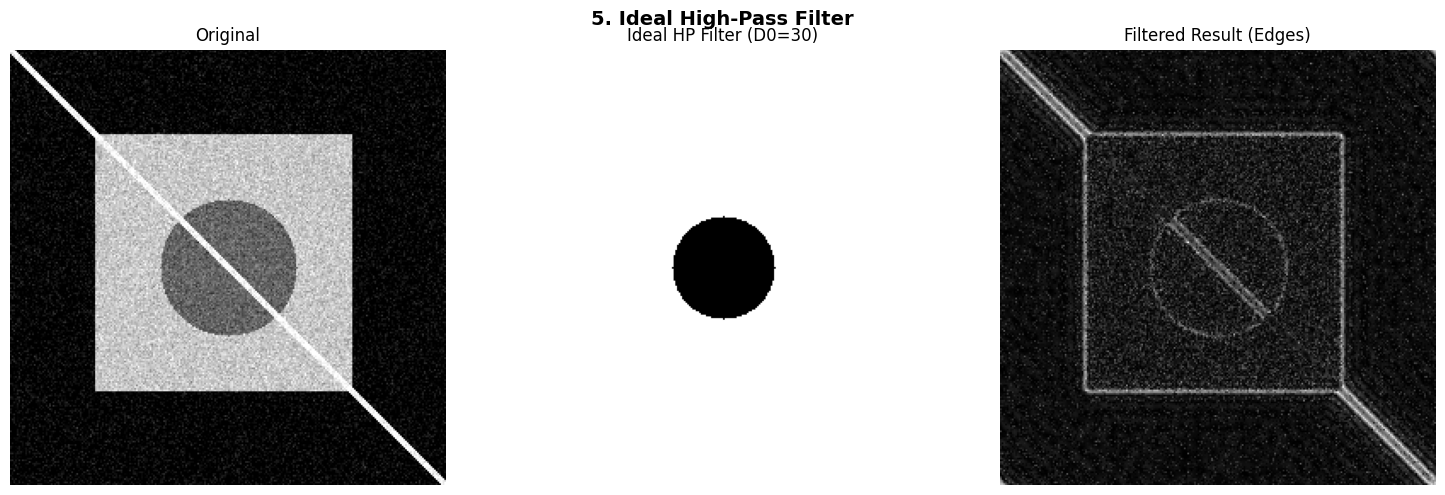

Formula: H(u,v) = 0 if D(u,v) <= 30, else 1


In [46]:
# 5. IDEAL HIGH-PASS FILTER

D0 = 30  # Cutoff frequency

# Create filter mask (opposite of low-pass)
H_ideal_hp = np.ones((rows, cols), dtype=np.float32)
H_ideal_hp[D <= D0] = 0

# Apply filter
filtered_dft = dft_shift * H_ideal_hp

# Inverse DFT
f_ishift = np.fft.ifftshift(filtered_dft)
result = np.abs(np.fft.ifft2(f_ishift))

# Display
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

ax[0].imshow(image, cmap='gray')
ax[0].set_title('Original')
ax[0].axis('off')

ax[1].imshow(H_ideal_hp, cmap='gray')
ax[1].set_title(f'Ideal HP Filter (D0={D0})')
ax[1].axis('off')

ax[2].imshow(result, cmap='gray')
ax[2].set_title('Filtered Result (Edges)')
ax[2].axis('off')

plt.suptitle('5. Ideal High-Pass Filter', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print(f"Formula: H(u,v) = 0 if D(u,v) <= {D0}, else 1")


## Formula

$$H(u,v) = \begin{cases} 0 & \text{if } D(u,v) \leq D_0 \\ 1 & \text{if } D(u,v) > D_0 \end{cases}$$

> **Note:** H_HP = 1 - H_LP (opposite of Low-Pass)

---

## The Three Images

| Image | Description |
|-------|-------------|
| **Original** | Input image |
| **Filter Mask** | Black circle = block, White = pass |
| **Result** | Edges detected, smooth areas removed |

---

## Key Points

- **Blocks low frequencies** (center) → removes smooth areas
- **Passes high frequencies** (edges) → keeps edges, details, noise
- **Ringing artifacts** visible due to sharp cutoff

---

---



---
## 6. Butterworth High-Pass Filter

**Formula:**
$$H(u,v) = \frac{1}{1 + \left(\frac{D_0}{D(u,v)}\right)^{2n}}$$

**Note:** D0 is now in the **numerator** (opposite of LP)


This filter extracts edges like Ideal HP but with a gradual transition, reducing ringing artifacts. It's useful for edge detection and image sharpening applications where you want cleaner results than the Ideal filter provides. The order (n) controls how sharp the transition is.

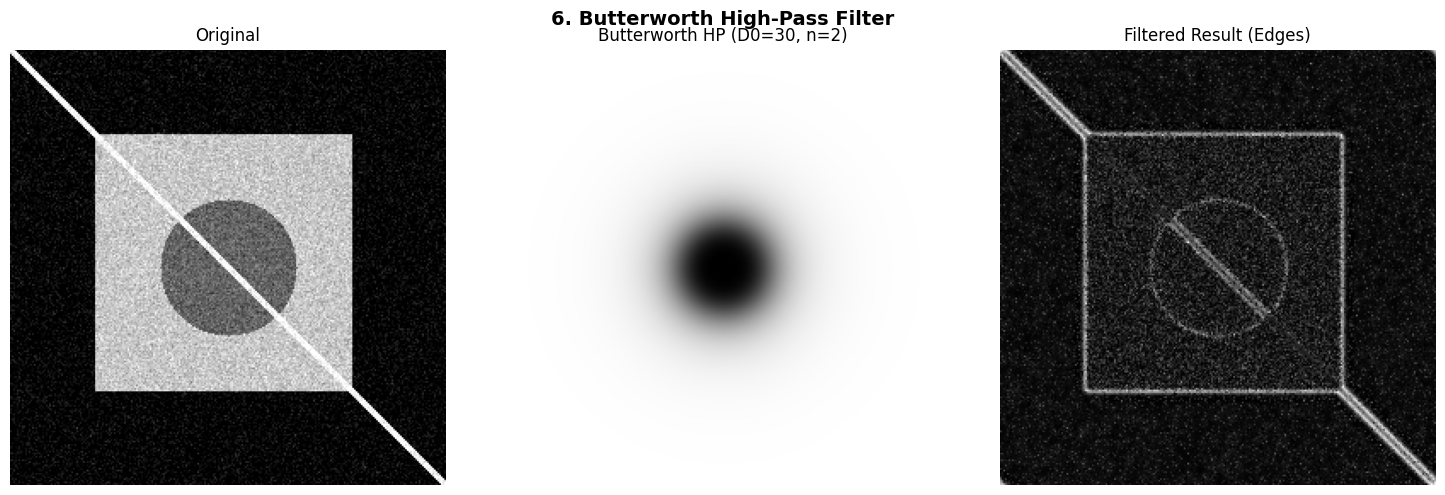

Formula: H(u,v) = 1 / (1 + (30/D)^4)


In [47]:
# 6. BUTTERWORTH HIGH-PASS FILTER

D0 = 30  # Cutoff frequency
n = 2    # Filter order

# Avoid division by zero
D_safe = np.maximum(D, 0.0001)

# Create filter mask (D0 in numerator!)
H_butter_hp = 1 / (1 + (D0 / D_safe) ** (2 * n))

# Apply filter
filtered_dft = dft_shift * H_butter_hp

# Inverse DFT
f_ishift = np.fft.ifftshift(filtered_dft)
result = np.abs(np.fft.ifft2(f_ishift))

# Display
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

ax[0].imshow(image, cmap='gray')
ax[0].set_title('Original')
ax[0].axis('off')

ax[1].imshow(H_butter_hp, cmap='gray')
ax[1].set_title(f'Butterworth HP (D0={D0}, n={n})')
ax[1].axis('off')

ax[2].imshow(result, cmap='gray')
ax[2].set_title('Filtered Result (Edges)')
ax[2].axis('off')

plt.suptitle('6. Butterworth High-Pass Filter', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print(f"Formula: H(u,v) = 1 / (1 + ({D0}/D)^{2*n})")


## Formula

$$H(u,v) = \frac{1}{1 + \left(\frac{D_0}{D(u,v)}\right)^{2n}}$$

> **Note:** D₀ is in **numerator** (opposite of LP)

---

## The Three Images

| Image | Description |
|-------|-------------|
| **Original** | Input image |
| **Filter Mask** | Gradual transition (black center → white edges) |
| **Result** | Clean edges, **minimal ringing** |

---

## Key Points

- **Smooth transition** from block to pass
- **Less ringing** than Ideal HP
- Order **n** controls sharpness of transition

---

---


---
## 7. Gaussian High-Pass Filter

**Formula:**
$$H(u,v) = 1 - e^{-\frac{D(u,v)^2}{2D_0^2}}$$

**Note:** This is simply `1 - Gaussian_LP`


The smoothest edge detector - it extracts edges with no ringing artifacts at all. Simply calculated as (1 - Gaussian LP), it provides the cleanest edge detection results. Best choice when you need high-quality edge extraction without any unwanted visual artifacts.

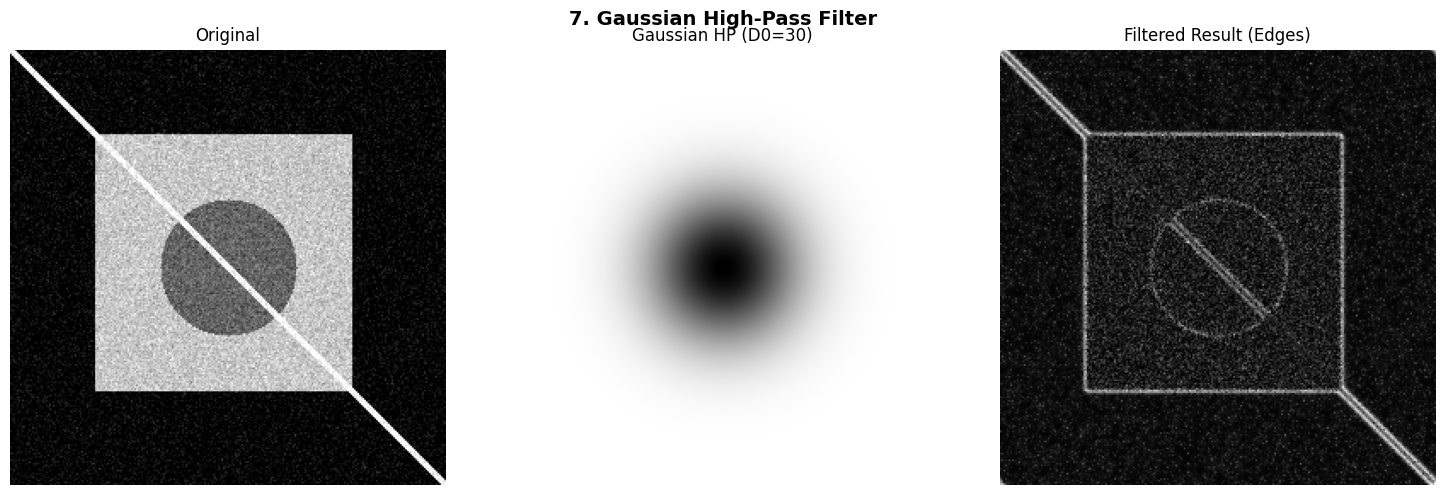

Formula: H(u,v) = 1 - exp(-D² / (2 * 30²))


In [48]:
# 7. GAUSSIAN HIGH-PASS FILTER

D0 = 30  # Cutoff frequency

# Create filter mask (1 - Gaussian LP)
H_gauss_hp = 1 - np.exp(-(D ** 2) / (2 * (D0 ** 2)))

# Apply filter
filtered_dft = dft_shift * H_gauss_hp

# Inverse DFT
f_ishift = np.fft.ifftshift(filtered_dft)
result = np.abs(np.fft.ifft2(f_ishift))

# Display
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

ax[0].imshow(image, cmap='gray')
ax[0].set_title('Original')
ax[0].axis('off')

ax[1].imshow(H_gauss_hp, cmap='gray')
ax[1].set_title(f'Gaussian HP (D0={D0})')
ax[1].axis('off')

ax[2].imshow(result, cmap='gray')
ax[2].set_title('Filtered Result (Edges)')
ax[2].axis('off')

plt.suptitle('7. Gaussian High-Pass Filter', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print(f"Formula: H(u,v) = 1 - exp(-D² / (2 * {D0}²))")



## Formula

$$H(u,v) = 1 - e^{-\frac{D(u,v)^2}{2D_0^2}}$$

> **Note:** H_HP = 1 - H_LP (one minus Gaussian LP)

---

## The Three Images

| Image | Description |
|-------|-------------|
| **Original** | Input image |
| **Filter Mask** | Smoothest transition |
| **Result** | Cleanest edges, **no artifacts** |

---

## Key Points

- **Smoothest transition** of all HP filters
- **No ringing artifacts**
- Best for clean edge detection

---

---


---
## 8. Laplacian in Frequency Domain

**Formula:**
$$H(u,v) = -4\pi^2(u^2 + v^2) = -4\pi^2 D(u,v)^2$$

**Simplified:** $H(u,v) = -D^2$

**Sharpening:** $g(x,y) = f(x,y) - c \cdot \nabla^2 f(x,y)$

The Laplacian is a second derivative operator that detects edges in all directions equally (isotropic). Unlike regular high-pass filters, it's specifically designed for image sharpening: by subtracting the Laplacian result from the original image (g = f - c×∇²f), edges become enhanced and the image appears sharper.

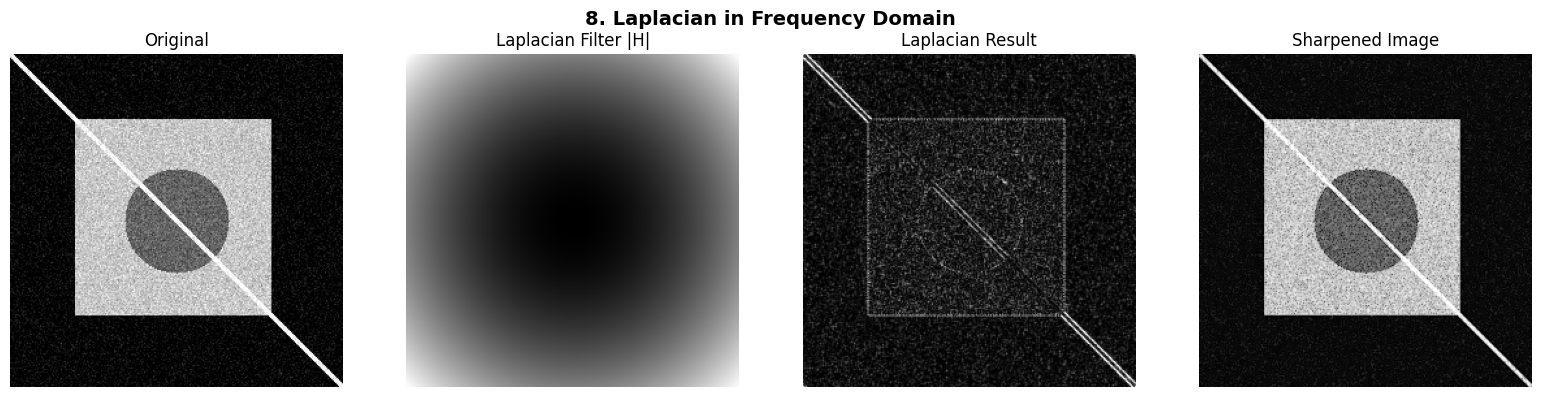

Formula: H(u,v) = -D²
Sharpening: g = f - 0.5 * Laplacian(f)


In [49]:
# 8. LAPLACIAN IN FREQUENCY DOMAIN

# Create Laplacian filter: H = -D²
H_laplacian = -(D ** 2)

# Normalize for practical use
H_laplacian_norm = H_laplacian / np.max(np.abs(H_laplacian))

# Apply filter
filtered_dft = dft_shift * H_laplacian_norm

# Inverse DFT
f_ishift = np.fft.ifftshift(filtered_dft)
laplacian_result = np.abs(np.fft.ifft2(f_ishift))

# Normalize for display
laplacian_display = cv2.normalize(laplacian_result, None, 0, 255, cv2.NORM_MINMAX)

# Sharpening: Original - c * Laplacian
c = 0.5  # Scaling constant
image_float = image.astype(np.float32)
laplacian_float = laplacian_display.astype(np.float32)
sharpened = image_float - c * (laplacian_float - laplacian_float.mean())
sharpened = np.clip(sharpened, 0, 255).astype(np.uint8)

# Display
fig, ax = plt.subplots(1, 4, figsize=(16, 4))

ax[0].imshow(image, cmap='gray')
ax[0].set_title('Original')
ax[0].axis('off')

ax[1].imshow(np.abs(H_laplacian_norm), cmap='gray')
ax[1].set_title('Laplacian Filter |H|')
ax[1].axis('off')

ax[2].imshow(laplacian_display, cmap='gray')
ax[2].set_title('Laplacian Result')
ax[2].axis('off')

ax[3].imshow(sharpened, cmap='gray')
ax[3].set_title('Sharpened Image')
ax[3].axis('off')

plt.suptitle('8. Laplacian in Frequency Domain', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("Formula: H(u,v) = -D²")
print(f"Sharpening: g = f - {c} * Laplacian(f)")


## Formula

$$H(u,v) = -D^2$$

**Sharpening:**
$$g = f - c \cdot \nabla^2 f$$

---

## The Four Images

| Image | Description |
|-------|-------------|
| **Original** | Input image |
| **Laplacian Filter \|H\|** | Emphasizes high frequencies (edges outward) |
| **Laplacian Result** | Detected edges (2nd derivative) |
| **Sharpened Image** | Original - 0.5 × Laplacian |

---

## Key Points

- **Second derivative** operator → detects edges
- **Isotropic** - same response in all directions
- Used for **image sharpening**: subtract Laplacian from original

---

## Sharpening Formula

```
g = f - c * Laplacian(f)
```

| Parameter | Value | Effect |
|-----------|-------|--------|
| **c** | 0.5 | Sharpening strength |

- c small → subtle sharpening
- c large → strong sharpening (may amplify noise)

---

## Laplacian vs High-Pass

| Laplacian | High-Pass |
|-----------|-----------|
| 2nd derivative | Blocks low freq |
| Detects edges | Extracts edges |
| Used for sharpening | Used for edge detection |


# Quick Summary Table

| Filter | One-Line Description |
|--------|---------------------|
| Spatial | Averages neighboring pixels directly |
| Ideal LP | Sharp cutoff blur (causes ringing) |
| Butterworth LP | Smooth cutoff blur (less ringing) |
| Gaussian LP | Smoothest blur (no ringing) |
| Ideal HP | Sharp cutoff edge detection (causes ringing) |
| Butterworth HP | Smooth cutoff edge detection (less ringing) |
| Gaussian HP | Smoothest edge detection (no ringing) |
| Laplacian | Second derivative for sharpening |

---
## Comparison: All Low-Pass Filters

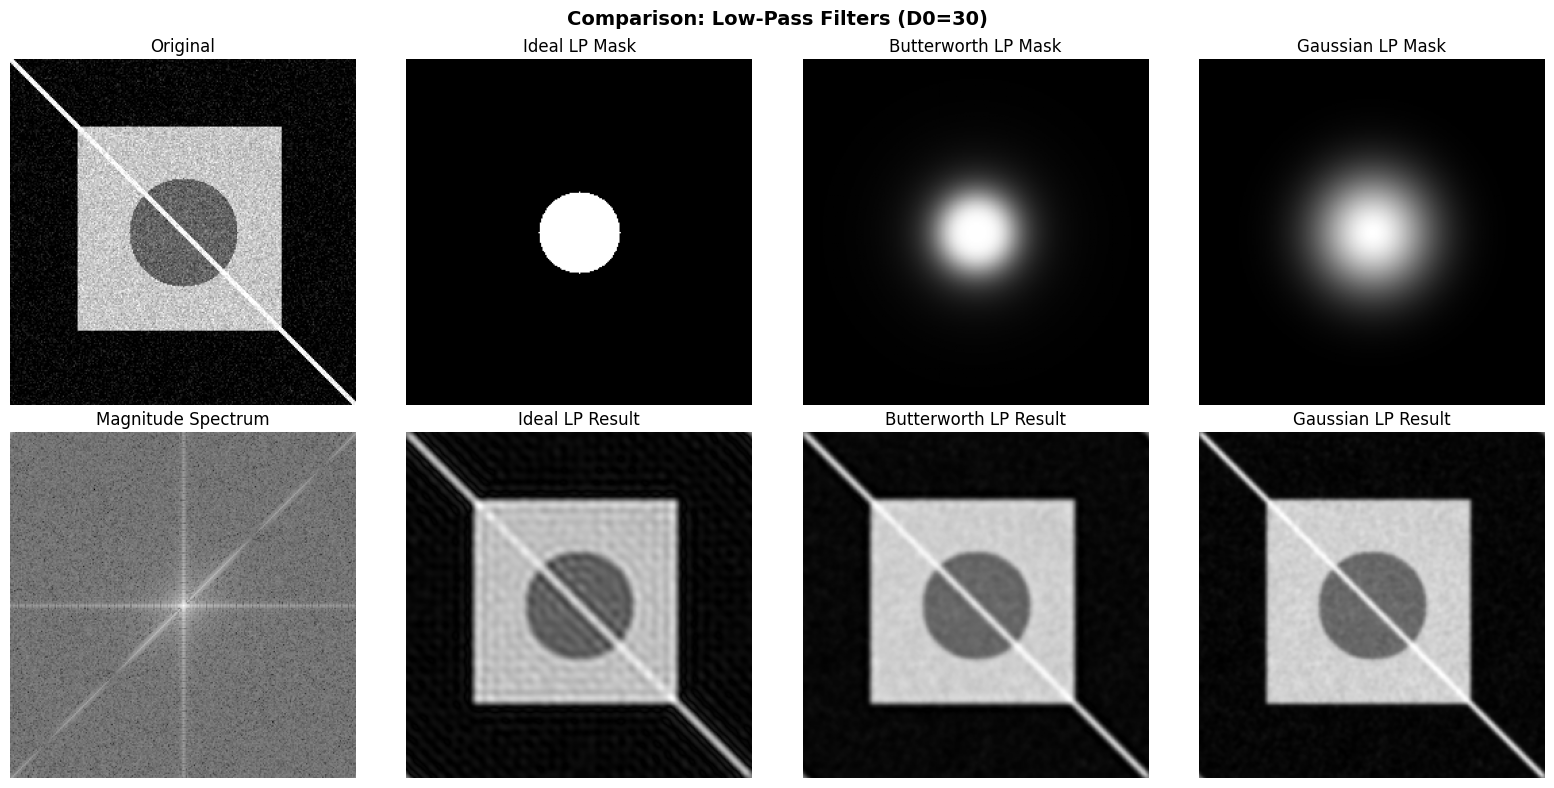

In [50]:
# COMPARISON: LOW-PASS FILTERS

D0 = 30
n = 2

# Create all LP filters
H_ideal = np.float32(D <= D0)
H_butter = 1 / (1 + (D / D0) ** (2 * n))
H_gauss = np.exp(-(D ** 2) / (2 * D0 ** 2))

# Apply and get results
results = {}
for name, H in [('Ideal', H_ideal), ('Butterworth', H_butter), ('Gaussian', H_gauss)]:
    filtered = dft_shift * H
    f_ishift = np.fft.ifftshift(filtered)
    results[name] = np.abs(np.fft.ifft2(f_ishift))

# Display
fig, ax = plt.subplots(2, 4, figsize=(16, 8))

# Row 1: Filters
ax[0, 0].imshow(image, cmap='gray')
ax[0, 0].set_title('Original')
ax[0, 1].imshow(H_ideal, cmap='gray')
ax[0, 1].set_title('Ideal LP Mask')
ax[0, 2].imshow(H_butter, cmap='gray')
ax[0, 2].set_title('Butterworth LP Mask')
ax[0, 3].imshow(H_gauss, cmap='gray')
ax[0, 3].set_title('Gaussian LP Mask')

# Row 2: Results
ax[1, 0].imshow(magnitude_spectrum, cmap='gray')
ax[1, 0].set_title('Magnitude Spectrum')
ax[1, 1].imshow(results['Ideal'], cmap='gray')
ax[1, 1].set_title('Ideal LP Result')
ax[1, 2].imshow(results['Butterworth'], cmap='gray')
ax[1, 2].set_title('Butterworth LP Result')
ax[1, 3].imshow(results['Gaussian'], cmap='gray')
ax[1, 3].set_title('Gaussian LP Result')

for a in ax.flat:
    a.axis('off')

plt.suptitle(f'Comparison: Low-Pass Filters (D0={D0})', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

---
## Comparison: All High-Pass Filters

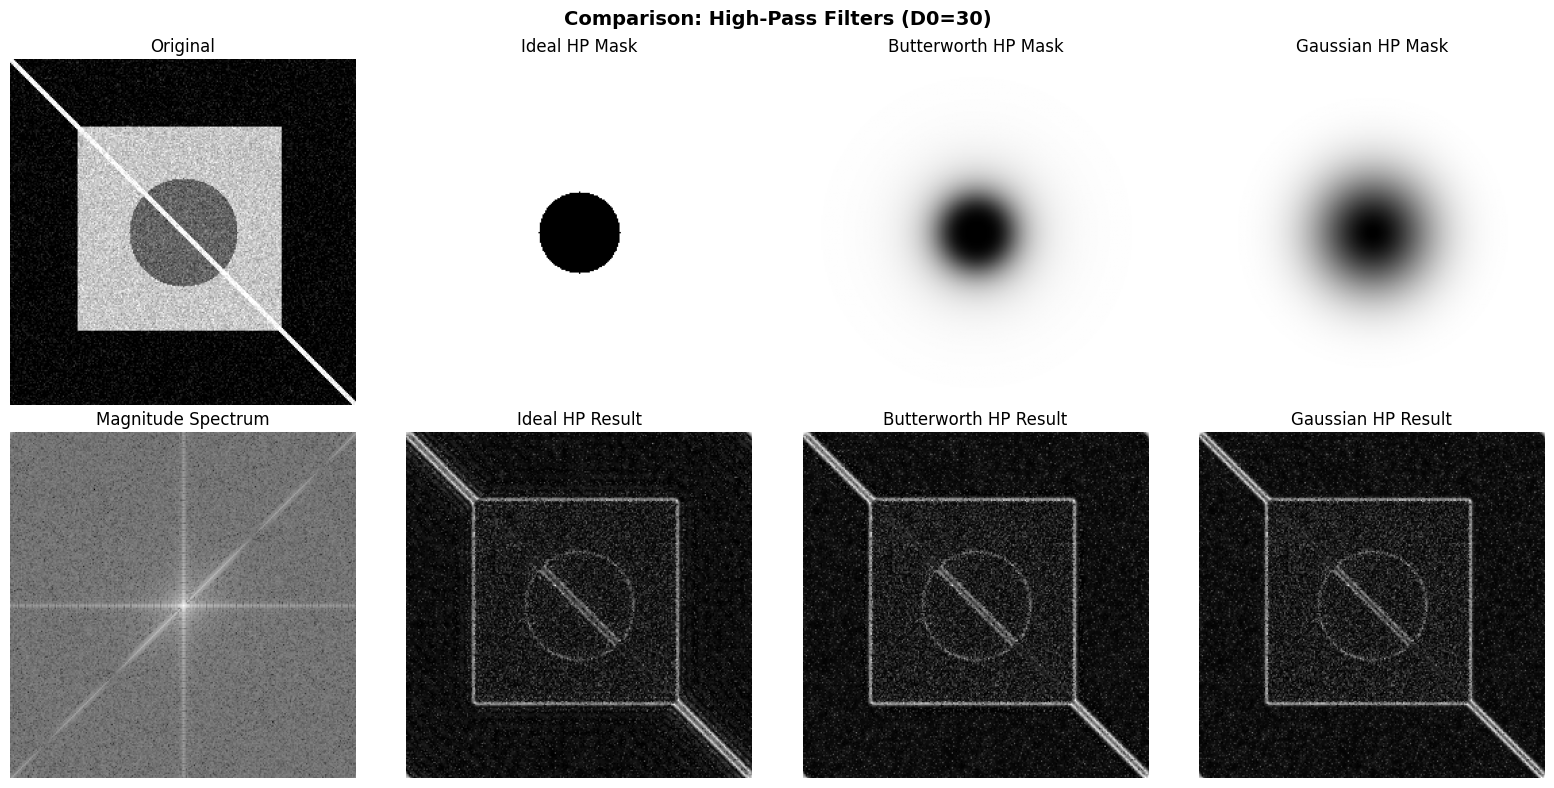

In [51]:
# COMPARISON: HIGH-PASS FILTERS

D0 = 30
n = 2
D_safe = np.maximum(D, 0.0001)

# Create all HP filters
H_ideal = np.float32(D > D0)
H_butter = 1 / (1 + (D0 / D_safe) ** (2 * n))
H_gauss = 1 - np.exp(-(D ** 2) / (2 * D0 ** 2))

# Apply and get results
results = {}
for name, H in [('Ideal', H_ideal), ('Butterworth', H_butter), ('Gaussian', H_gauss)]:
    filtered = dft_shift * H
    f_ishift = np.fft.ifftshift(filtered)
    results[name] = np.abs(np.fft.ifft2(f_ishift))

# Display
fig, ax = plt.subplots(2, 4, figsize=(16, 8))

# Row 1: Filters
ax[0, 0].imshow(image, cmap='gray')
ax[0, 0].set_title('Original')
ax[0, 1].imshow(H_ideal, cmap='gray')
ax[0, 1].set_title('Ideal HP Mask')
ax[0, 2].imshow(H_butter, cmap='gray')
ax[0, 2].set_title('Butterworth HP Mask')
ax[0, 3].imshow(H_gauss, cmap='gray')
ax[0, 3].set_title('Gaussian HP Mask')

# Row 2: Results
ax[1, 0].imshow(magnitude_spectrum, cmap='gray')
ax[1, 0].set_title('Magnitude Spectrum')
ax[1, 1].imshow(results['Ideal'], cmap='gray')
ax[1, 1].set_title('Ideal HP Result')
ax[1, 2].imshow(results['Butterworth'], cmap='gray')
ax[1, 2].set_title('Butterworth HP Result')
ax[1, 3].imshow(results['Gaussian'], cmap='gray')
ax[1, 3].set_title('Gaussian HP Result')

for a in ax.flat:
    a.axis('off')

plt.suptitle(f'Comparison: High-Pass Filters (D0={D0})', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

---
## Summary: Filter Formulas

| Filter | Formula | Notes |
|--------|---------|-------|
| **Ideal LP** | H = 1 if D ≤ D₀, else 0 | Sharp cutoff, ringing |
| **Butterworth LP** | H = 1 / (1 + (D/D₀)^2n) | Smooth, n controls sharpness |
| **Gaussian LP** | H = exp(-D² / 2D₀²) | Smoothest, no ringing |
| **Ideal HP** | H = 0 if D ≤ D₀, else 1 | = 1 - Ideal_LP |
| **Butterworth HP** | H = 1 / (1 + (D₀/D)^2n) | D₀ in numerator |
| **Gaussian HP** | H = 1 - exp(-D² / 2D₀²) | = 1 - Gaussian_LP |
| **Laplacian** | H = -D² | Edge detection |

# Filter Parameters and Their Impact

---

## 1. Spatial Domain Filters

| Parameter | Values | Impact |
|-----------|--------|--------|
| **Kernel size** | 3, 5, 7, 9... | Larger = more blur, slower |

```python
cv2.blur(image, (5, 5))        # 5x5 kernel
cv2.GaussianBlur(image, (7, 7), 0)  # 7x7 kernel
cv2.medianBlur(image, 5)       # 5x5 kernel
```

---

## 2. Ideal Low-Pass Filter

| Parameter | Values | Impact |
|-----------|--------|--------|
| **D₀** (cutoff) | 10, 30, 50, 80... | Lower = more blur, Higher = less blur |

| D₀ | Effect |
|----|--------|
| 10 | Very blurry |
| 30 | Moderate blur |
| 80 | Slight blur |

---

## 3. Butterworth Low-Pass Filter

| Parameter | Values | Impact |
|-----------|--------|--------|
| **D₀** (cutoff) | 10, 30, 50... | Lower = more blur |
| **n** (order) | 1, 2, 3, 4... | Higher = sharper transition (→ Ideal) |

| n | Transition |
|---|------------|
| 1 | Very smooth |
| 2 | Moderate (common) |
| 4+ | Sharp (approaches Ideal) |

---

## 4. Gaussian Low-Pass Filter

| Parameter | Values | Impact |
|-----------|--------|--------|
| **D₀** (cutoff) | 10, 30, 50... | Lower = more blur |

> No order parameter - always smoothest transition.

---

## 5. Ideal High-Pass Filter

| Parameter | Values | Impact |
|-----------|--------|--------|
| **D₀** (cutoff) | 10, 30, 50... | Lower = more edges, Higher = fewer edges |

| D₀ | Effect |
|----|--------|
| 10 | Thick edges, more detail |
| 30 | Moderate edges |
| 80 | Only strongest edges |

---

## 6. Butterworth High-Pass Filter

| Parameter | Values | Impact |
|-----------|--------|--------|
| **D₀** (cutoff) | 10, 30, 50... | Lower = more edges |
| **n** (order) | 1, 2, 3... | Higher = sharper transition |

---

## 7. Gaussian High-Pass Filter

| Parameter | Values | Impact |
|-----------|--------|--------|
| **D₀** (cutoff) | 10, 30, 50... | Lower = more edges |

---

## 8. Laplacian in Frequency Domain

| Parameter | Values | Impact |
|-----------|--------|--------|
| **c** (sharpening constant) | 0.1 - 2.0 | Higher = stronger sharpening |

| c | Effect |
|---|--------|
| 0.3 | Subtle sharpening |
| 0.5 | Moderate sharpening |
| 1.0+ | Strong sharpening (may amplify noise) |

---

## Summary Table

| Filter | Parameter(s) | Main Effect |
|--------|--------------|-------------|
| Spatial | kernel size | Blur amount |
| Ideal LP | D₀ | Blur amount |
| Butterworth LP | D₀, n | Blur + transition sharpness |
| Gaussian LP | D₀ | Blur amount |
| Ideal HP | D₀ | Edge thickness |
| Butterworth HP | D₀, n | Edge + transition sharpness |
| Gaussian HP | D₀ | Edge thickness |
| Laplacian | c | Sharpening strength |

---

## Key Takeaways

- **D₀ (cutoff)**: Controls how much frequency passes through
- **n (order)**: Only in Butterworth - controls transition sharpness
- **c (constant)**: Only in Laplacian - controls sharpening strength
- **kernel size**: Only in spatial - controls blur amount